# Deep Learning for Computer Vision

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Florient Chouteau | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

# Session 1 : About Convolutions and CNNs ...



<div class = "alert alert-warning">

**Deep Learning appliqué sur de l'imagerie satellite** 
- Détecter des avions dans une image satellite


**Contexte : observation de la Terre par satellite**
- Acquisition d'images pour monitoring, surveillance d'environnement, etc.
- Satellites optiques ou multi-spectral (pour l'analyse de l'environnement)
- Problème : aiguille dans la botte de foin, bcp de données, peu d'informations intéressantes 
    - Chercher les avions dans les aéroports : ok on peut regarder que les images pris sur les aéroports
    - Chercher les avions au-dessus de l'atlantique : pas facile...
- Objectif : attirer l'attention d'un opérateur humain sur une partie des images (filtrer sur les images intéressantes)
    
    
    # Import torch
    import torch
    from torch import nn, optim
    
    # Nouveau modèle
    device = torch.device(...) #CPU, GPU or TPU
    model = nn.Sequential(...).to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.SGD(model.parameters())
    
    # Entraînement
    for (x,y) in dataset : 
    y = model(x)
    ...

Welcome to this BE about applying Deep Learning for Computer Vision

We have 6 hours to do an hands on with something that looks like what you could be doing in three months time (but simplified)

We have four notebooks to go through during those 6 hours :

- One general for to get a better grasp about CNNs (it should be very quick)
- One where we will train a small aircraft classifier on a "simple" dataset and plot performance curves
- One where we will train an aircraft classifier on a more realistic dataset and plot performance curves
- The last one we will take our previously trained model and use it for real ;)

It is recommended to use Google Colab to run these notebooks

## Images

A digital image is an image composed of picture elements, also known as pixels, each with finite, discrete quantities of numeric representation for its intensity or gray level that is an output from its two-dimensional functions fed as input by its spatial coordinates denoted with x, y on the x-axis and y-axis, respectively.

We represent images as matrixes,

Images are made of pixels, and pixels are made of combinations of primary colors (in our case Red, Green and Blue). In this context, images have chanels that are the grayscale image of the same size as a color image, made of just one of these primary colors. For instance, an image from a standard digital camera will have a red, green and blue channel. A grayscale image has just one channel.

In remote sensing, channels are often referred to as raster bands.

<img src="https://miro.medium.com/max/1400/1*icINeO4H7UKe3NlU1fXqlA.jpeg" alt="drawing" width="400"/>

For the rest of this workshop we will use the following axis conventions for images

![conventions](https://storage.googleapis.com/fchouteau-isae-deep-learning/static/image_coordinates.png)

The reference library in python for working with images is https://scikit-image.org/

We will just do basic image manipulation, but you [can look at all the examples](https://scikit-image.org/docs/stable/auto_examples/) if you need to get a better grasp of image processing

In [44]:
import numpy as np
import skimage
import skimage.data
from matplotlib import pyplot as plt

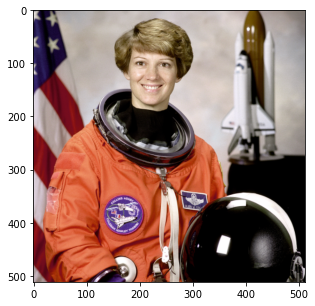

In [118]:
img = skimage.data.astronaut()

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()

<class 'numpy.ndarray'>
(512, 512, 3)


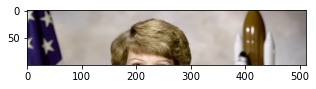

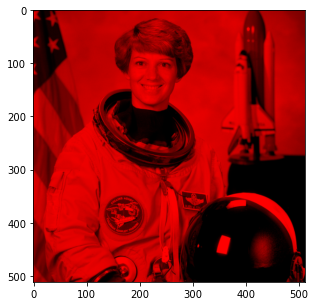

dtype('uint8')

In [123]:
# What is the height, width and number of channels of this image ?

print(type(img))
print(img.shape)
# hauteur et largeur de 512 
# 3 canaux par pixel (RGB)

# In which order is the data represented ? Which dimensions are channels in ?

L1 = img[0:100,:,:]
plt.figure(figsize=(5, 5))
plt.imshow(L1)
plt.show()

# Le premier axe est la ligne
# Le deuxième axe est la colonne
# Le troisième axe est la couleur

test = skimage.data.astronaut()
test[:,:,1] = 0
test[:,:,2] = 0
plt.figure(figsize=(5, 5))
plt.imshow(test)
plt.show()
# Le premier canal est le rouge
# Le deuxième canal est le vert
# Le troisème canal est le bleu

# What is the image "dtype" ?

img = skimage.data.astronaut()
img.dtype

# Les pixels sont représentés par des entiers non signés de 8 bits

(128, 128, 3)


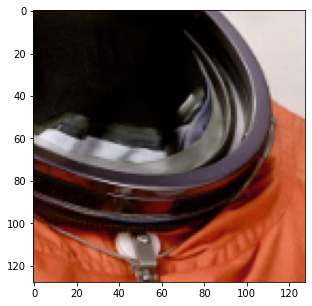

In [124]:
# Extract the center 128 x 128 pixels on all three bands and plot it

taille_img = 128
Start = int((len(img) - taille_img)/2)
End = Start + taille_img
center_img = img[Start:End,Start:End,:]

print(center_img.shape)

plt.figure(figsize=(5, 5))
plt.imshow(center_img)
plt.show()

In classical image representation, we use the [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model) where the image is represented by three R,G,B channels (in that order).

Usually we also use 8bits color depth

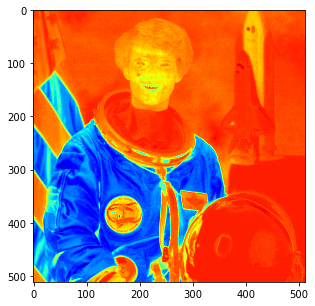

In [102]:
# Plot the difference between the green and the red band
# don't forget to convert the image type as the image are in unsigned type

red = img[:,:,0]
green = img[:,:,1]
blue = img[:,:,2]

red_int = np.ndarray(shape=(512,512), dtype=int)
green_int = np.ndarray(shape=(512,512), dtype=int)
for i in range(int(len(img))):
    for j in range(int(len(img))):
        red_int[i,j] = int(red[i,j])
        green_int[i,j] = int(green[i,j])

diff_GR = green_int - red_int

plt.figure(figsize = (5,5))
plt.imshow(diff_GR, cmap = "jet")
plt.show()

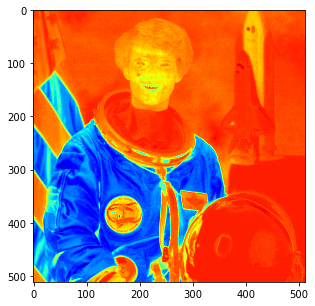

In [101]:
r = img[:,:,0].astype(np.float32)
g = img[:,:,1].astype(np.float32)

plt.figure(figsize = (5,5))
plt.imshow(g-r, cmap = "jet")
plt.show()

### Convolutions

You've seen this image in the previous class :

<img src="https://i.stack.imgur.com/FjvuN.gif" alt="drawing" width="400"/>

This is a convolution operator.

Someone may have told you that CNNs were the "thing" that made deep learning for image processing possible. But what are convolutions ?

First, remember that you [learnt about convolutions a long time ago 😱](https://fr.wikipedia.org/wiki/Produit_de_convolution)

<img src="https://betterexplained.com/ColorizedMath/content/img/Convolution.png" alt="drawing" width="400"/>

So basically, we slide a filter over the signal. In 2D, this means

<img src="https://miro.medium.com/max/535/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" alt="drawing" width="400"/>

One thing you can notice is that if we slide a filter over an image we "lose" pixels at the border. This is actually quite easy to compute : assuming a of size `2*k +1` we loose `k` pixels on each side of the image.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

If you want to get them back you have to "pad" (add values at the border, for examples zeroes) the image

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/arbitrary_padding_no_strides.gif)

For more information, this website is excellent : https://cs231n.github.io/convolutional-networks/#conv

Let's play with convolutions a little bit before actually doing CNNs.

### 2D Convolution without "depth"

First, let's look at basic filtering over grayscale (1 channel) images. We will slide a filter over H,W spatial dimensions and get the result

First, the convolution implementation without depth is quite simple : 

In [142]:
def convolve(img: np.array, kernel: np.array) -> np.array:
    k = kernel.shape[0]
    h, w = img.shape[:2]
    p = int(k // 2)

    # 2D array of zeros
    kernel = kernel.astype(np.float32)
    img = img.astype(np.float32)
    convolved_img = np.zeros(shape=(h - 2 * p, w - 2 * p)).astype(np.float32)

    # Iterate over the rows
    for i in range(h - 2 * p):
        # Iterate over the columns
        for j in range(w - 2 * p):
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = img[i : i + k, j : j + k]

            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))

    convolved_img = convolved_img.clip(0.0, 255.0).astype(np.uint8)

    return convolved_img

What happens if I use this filter as input ?

![identity](https://wikimedia.org/api/rest_v1/media/math/render/svg/1fbc763a0af339e3a3ff20af60a8a993c53086a7)

In [143]:
k = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
k = np.asarray(k)

k.shape
print(k)

[[0 0 0]
 [0 1 0]
 [0 0 0]]


(300, 451)


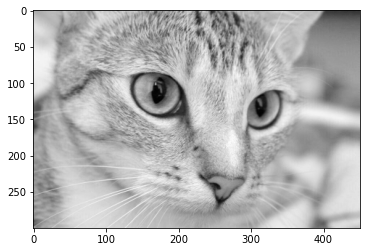

In [144]:
img = skimage.data.cat()
img = img[:, :, 0]

print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

(298, 449)


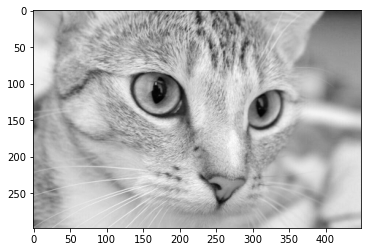

before (302, 453)
after (300, 451)


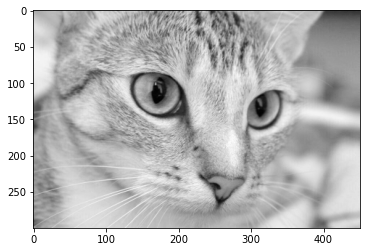

In [145]:
convolved_img = convolve(img, k)

print(convolved_img.shape)

plt.imshow(convolved_img, cmap="gray")
plt.show()

# Note the loss of 1 pixel... If we wanted to alleviate it we could do something like

img = np.pad(img, ((1, 1), (1, 1)))
print(f"before {img.shape}")
convolved_img = convolve(img, k)

print(f"after {convolved_img.shape}")

plt.imshow(convolved_img, cmap="gray")
plt.show()

Too easy ! Let's try another filter

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/91256bfeece3344f8602e288d445e6422c8b8a1c)

What does it do ? Take a guess

In [146]:
k = np.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]]).astype(np.float32)
k = k / k.sum()
print(k)

# Ce filtre floute l'image en remplaçant chaque pixel par la moyenne des 9 pixels (lui-même et ses voisins)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


(300, 451)


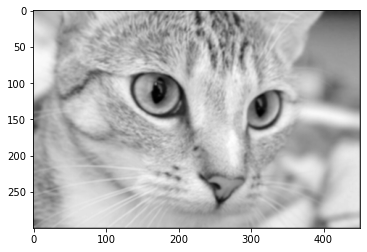

In [147]:
# Convolve the cat image with this filter and plot it
convolved_img_2 = convolve(img, k)

print(convolved_img_2.shape)

plt.imshow(convolved_img_2, cmap="gray")
plt.show()

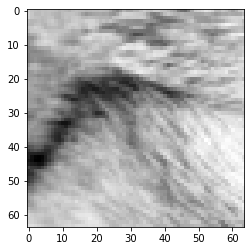

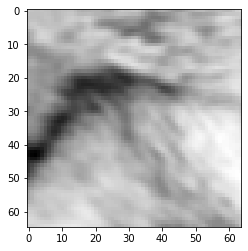

In [148]:
plt.imshow(img[64:128, 64:128], cmap="gray")
plt.show()
plt.imshow(convolved_img_2[64:129, 64:128], cmap="gray")
plt.show()

# on voit en zoomant que l'image a bien été floutée par rapport à l'image initiale

If we wanted, we could learn the filters in order to do... cat classification !

### Convolutions with depth

Let's get back to our GIF

<img src="https://i.stack.imgur.com/FjvuN.gif" alt="drawing" width="400"/>

It's the same as above, except our filter takes all channels of the image as input. So basically a "Convolution" layer is a filter

**Important**

In classical image processing, we use the (height, width, channels) convention, however in torch we prefer using (channels, height, width) convention 

In [156]:
img = skimage.data.astronaut()
img.shape

(512, 512, 3)

In [157]:
# To transpose an image, we use
img = img.transpose((2, 0, 1))  # change channel order to prefered order in torch
img.shape

# On met la couleur en premier axe

(3, 512, 512)

In [158]:
w = np.random.random((1, 3, 3, 3))
b = np.random.random((3,))

In [159]:
# You should remember this

def forward_convolution(conv_W, conv_b, data):
    """
    Compute the output from a convolutional layer given the weights and data.

    conv_W is of the shape (# output channels, # input channels, convolution width, convolution height )
    conv_b is of the shape (# output channels)

    data is of the shape (# input channels, width, height)

    The output should be the result of a convolution and should be of the size:
        (# output channels, width - convolution width + 1, height -  convolution height + 1)

    Returns:
        The output of the convolution as a numpy array
    """

    conv_channels, _, conv_width, conv_height = conv_W.shape

    input_channels, input_width, input_height = data.shape

    output = np.zeros((conv_channels, input_width - conv_width + 1, input_height - conv_height + 1))

    for x in range(input_width - conv_width + 1):
        for y in range(input_height - conv_height + 1):
            for output_channel in range(conv_channels):
                output[output_channel, x, y] = (
                    np.sum(
                        np.multiply(
                            data[:, x : (x + conv_width), y : (y + conv_height)], conv_W[output_channel, :, :, :]
                        )
                    )
                    + conv_b[output_channel]
                )

    return output

Input (3, 512, 512)
Filter:
 [[[[0.97745763 0.65075263 0.39802242]
   [0.16624848 0.83362416 0.40658105]
   [0.66376932 0.51796412 0.33417133]]

  [[0.55825888 0.50595334 0.42398147]
   [0.47095757 0.75590525 0.7446479 ]
   [0.0235093  0.6748667  0.17054379]]

  [[0.85622904 0.07213957 0.7547228 ]
   [0.20789676 0.71276197 0.3983759 ]
   [0.92175745 0.42189301 0.67192933]]]] (1, 3, 3, 3)
Bias: [0.55720696 0.43841037 0.24136768] (3,)
Input (1, 510, 510)


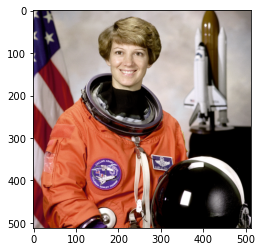

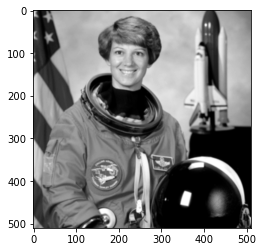

In [167]:
rng = np.random.default_rng()

output = forward_convolution(w, b, img)
print("Input", img.shape)
print("Filter:\n", w, w.shape)
print("Bias:", b, b.shape)
print("Input", output.shape)

# Don't forget that matplotlib uses (h,w,c) to plot images !

plt.imshow(img.transpose(1, 2, 0))
plt.show()
plt.imshow(output.transpose((1, 2, 0))[:,:,0], cmap="gray")
plt.show()

Some useful resources for more information :

- The DL class https://github.com/fchouteau/deep-learning/blob/main/deep/Deep%20Learning.ipynb
- https://github.com/vdumoulin/conv_arithmetic
- https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1

## Convolutional Neural Networks

I shamelessly copy pasted code from this excellent class : https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb

Remember, an Artificial Neural Network is a stack of 

    "Fully Connected" layers
    Non linearities

A Convolutional Neural Network is a stack of
- Convolutional Layers aka Filter Banks
    - Increase dimensionality
    - Projection on overcomplete basis
    - Edge detections
- Non-linearities
    - Sparsification
    - Typically Rectified Linear Unit (ReLU): ReLU(x)=max⁡(x,0)\text{ReLU}(x) = \max(x, 0)ReLU(x)=max(x,0)
- Pooling
    - Aggregating over a feature map
    - Example : Maximum

![](https://cdn-media-1.freecodecamp.org/images/Dgy6hBvOvAWofkrDM8BclOU3E3C2hqb25qBb)

Why do CNNs works ?

To perform well, we need to incorporate some prior knowledge about the problem

    Assumptions helps us when they are true
    They hurt us when they are not
    We want to make just the right amount of assumptions, not more than that
    
In Deep Learning

    Many layers: compositionality
    Convolutions: locality + stationarity of images
    Pooling: Invariance of object class to translations

In [161]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [162]:
input_size = 28 * 28  # images are 28x28 pixels
output_size = 10  # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
    ),
    batch_size=64,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data",
        train=False,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
    ),
    batch_size=1000,
    shuffle=True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



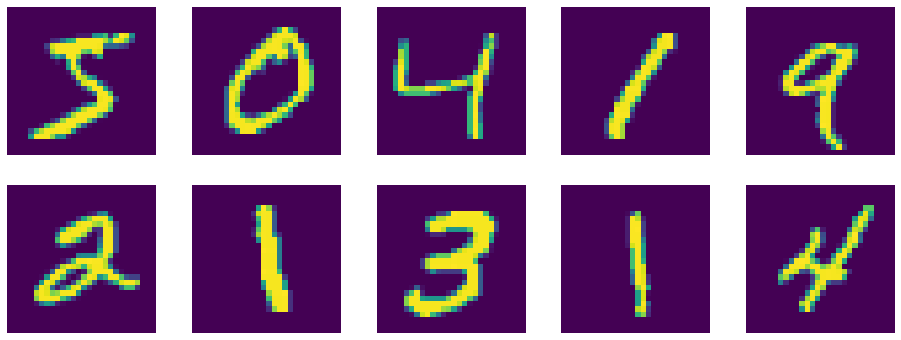

In [168]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis("off");

In [169]:
# function to count number of parameters
def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np


# Create two models: One ANN vs One CNN


class FullyConnected2Layers(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FullyConnected2Layers, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)


class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [170]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [171]:
accuracy_list = []


def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28 * 28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28 * 28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction="sum").item()  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), accuracy
        )
    )

### CNNs vs Fully Connected Layers

A small FullyConnected ANN

In [172]:
n_hidden = 8  # number of hidden units

model_fnn = FullyConnected2Layers(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print("Number of parameters: {}".format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.323714
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.827820
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.100580
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.626823
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.772263
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.706977
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.426305
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.364187
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.456022
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.354749

Test set: Average loss: 0.4161, Accuracy: 8768/10000 (88%)



A CNN with the same number of parameters

In [173]:
# Training settings
n_features = 6  # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print("Number of parameters: {}".format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.311503
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.104658
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.665390
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.455458
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.293014
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.140836
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.141967
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.267272
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.182411
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.136392

Test set: Average loss: 0.1516, Accuracy: 9537/10000 (95%)



The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

    Use of convolution: Locality and stationarity in images
    Pooling: builds in some translation invariance

### What happens when CNNs assumptions are not true ?

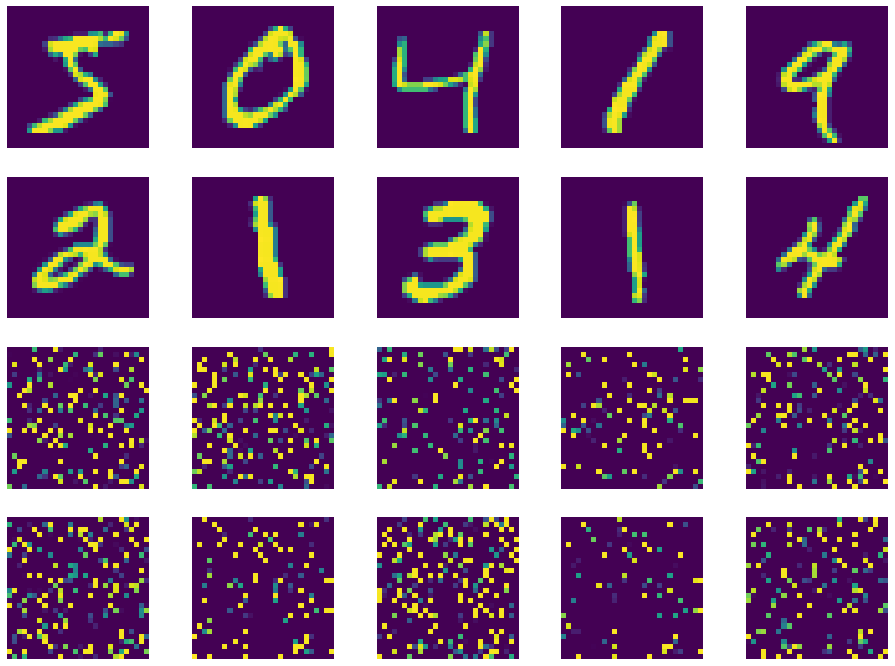

In [174]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28 * 28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis("off")
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis("off")

In [175]:
# Training settings
n_features = 6  # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print("Number of parameters: {}".format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.317581
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.293617
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.134383
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.750516
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.168747
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.877060
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.502391
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.625223
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.585268
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.608747

Test set: Average loss: 0.5372, Accuracy: 8378/10000 (84%)



In [176]:
n_hidden = 8  # number of hidden units

model_fnn = FullyConnected2Layers(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print("Number of parameters: {}".format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.282961
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.825309
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.420906
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.073200
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.795567
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.633169
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.585462
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.502340
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.370661
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.434692

Test set: Average loss: 0.4272, Accuracy: 8825/10000 (88%)




The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

    ConvNet makes the assumption that pixels lie on a grid and are stationary/local
    It loses performance when this assumption is wrong
    The fully-connected network does not make this assumption
    It does less well when it is true, since it doesn't take advantage of this prior knowledge
    But it doesn't suffer when the assumption is wrong

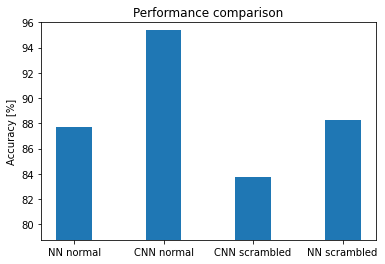

In [177]:
plt.bar(("NN normal", "CNN normal", "CNN scrambled", "NN scrambled"), accuracy_list, width=0.4)
plt.ylim((min(accuracy_list) - 5, 96))
plt.ylabel("Accuracy [%]")
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.title("Performance comparison");